# Loop for running bnpstep to fit existing FIONA traces

### Import necessary packages

In [4]:
# All inputs
import importlib
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import scipy.io
import os
import bnpstep as bnp
importlib.reload(bnp)

def insert_before_pattern(fname, insert_str, pattern):
    idx = fname.find(pattern)
    if idx == -1:
        return fname  # return unchanged
    return fname[:idx] + insert_str + fname[idx:]

### Select (multiple) .mat fiona files for loading

In [2]:
# This is the GUI of files selection. Only works for MacOS now
'''
# Select .mat fiona files for loading

# Hide the main tkinter window
root = tk.Tk()
root.withdraw()

# Open file dialog to select multiple files
file_paths = filedialog.askopenfilenames(
    title='Select .mat files',
    filetypes=[('MAT files', '*.mat')]
)

# file_paths is a tuple of strings (paths)
print("Number of files: ", len(file_paths))
print(list(file_paths))  # Convert to list if needed
'''

'\n# Select .mat fiona files for loading\n\n# Hide the main tkinter window\nroot = tk.Tk()\nroot.withdraw()\n\n# Open file dialog to select multiple files\nfile_paths = filedialog.askopenfilenames(\n    title=\'Select .mat files\',\n    filetypes=[(\'MAT files\', \'*.mat\')]\n)\n\n# file_paths is a tuple of strings (paths)\nprint("Number of files: ", len(file_paths))\nprint(list(file_paths))  # Convert to list if needed\n'

In [6]:
file_paths = [r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\241113-01-100126_47094_fiona.mat']
n_samples = 10

### Run through all files and save bnpstep results in .mat and .pkl format

Note: We will read the step number in the trace to give us an estimate of number of steps. It might slightly increase time, but it is necessary to make sure we aren't overloading the matrices. It seems by parameter sweep that 10000 iterations is good to get most of the convergence by eye.

In [7]:
# now run and save all results to load in later for the trace long-axis. (Short-axis to come later)

for i in range(len(file_paths)):
    start_time = time.perf_counter()
    matdata = scipy.io.loadmat(file_paths[i], squeeze_me=False, struct_as_record=True)
    p = Path(file_paths[i])

    # print(matdata['data'].dtype)
    data_struct = matdata['data'][0, 0]  # Extract the struct instance
    # for name in matdata['data'].dtype.names:
    #     field = data_struct[name]
    #     print(f"{name}: type = {type(field)}, shape = {getattr(field, 'shape', None)}")

    # for name in matdata['data'].dtype.names:
    #     print(name, data_struct[name])

    # Write a csv to load data, then immediately delete
    # Remove Nan's they don't need to be there
    data_struct['time'] = data_struct['time'][~np.isnan(data_struct['time'])]
    data_struct['trace'] = data_struct['trace'][~np.isnan(data_struct['trace'][:,0])]
    
    # t_trace_arr = np.array([data_struct['time'].reshape(len(data_struct['time']),1).flatten(), data_struct['trace'][:,0].reshape(len(data_struct['time']),1).flatten()])
    t_trace_arr = np.array(data_struct['trace'][:,0].reshape(len(data_struct['time']),1).flatten())    
    # t_trace_arr = t_trace_arr.reshape(len(data_struct['time']),2)
    t_trace_arr = t_trace_arr.transpose()
    print(t_trace_arr.shape)
    np.savetxt(str(p.parent)+'/'+p.stem+'_tempdata.csv', t_trace_arr, delimiter=',')

    # Initialize the data with the sampler with about twice as many steps as the user found
    A = data_struct['trace'][:,2]
    estimated_steps = np.sum(np.roll(A,1)!=A)
    if estimated_steps > 512/1.7:
        print('skipping', p.stem, 'for too many steps')
    else:
        sampler = bnp.BNPStep(B_max=int(2*estimated_steps))
        sampler.load_data(str(p.parent)+'/'+p.stem+'_tempdata.csv', has_timepoints=False)

        # if os.path.exists('tests/tempdata.csv'):
        #     os.remove('tests/tempdata.csv')
        #     print("File deleted.")
        # else:
        #     print("File not found.")

        # Now find the steps
        print("Sampler initialized with max steps:", int(1.7*estimated_steps), "sampling for", n_samples, "iterations.")
        sampler.analyze(num_samples= n_samples)
        sampler.results_to_file(outfile=str(p.parent)+'/'+p.stem+'_trial_sample')
        # sampler.visualize_results(plot_type='step')

        # change the trace fit after we did the new fitting
        '''
        new_steps = sampler.export_step_data()
        data_struct['trace'][:,2] = np.reshape(new_steps, data_struct['trace'][:,2].shape)

        # Now build the dictionary again and rewrite it to the new filename
        # Build the dictionary dynamically
        new_filename = insert_before_pattern(file_paths[i], "_bnpstep", "_fiona")
        rewritematdata = {'data': {}}

        for name in matdata['data'].dtype.names:
            rewritematdata['data'][name] = data_struct[name]

        scipy.io.savemat(new_filename, rewritematdata)        '''
        
    end_time = time.perf_counter()
    duration = end_time - start_time
    print(f"Iteration took {duration:.6f} seconds", len(sampler.Wacc))

(1221,)
Sampler initialized with max steps: 45 sampling for 10 iterations.
Iteration took 0.380415 seconds 1221


In [7]:
# now run and save all results to load in later for the trace short-axis

for i in range(len(file_paths)):
    matdata = scipy.io.loadmat(file_paths[i], squeeze_me=False, struct_as_record=True)
    p = Path(file_paths[i])

    # print(matdata['data'].dtype)
    data_struct = matdata['data'][0, 0]  # Extract the struct instance
    # for name in matdata['data'].dtype.names:
    #     field = data_struct[name]
    #     print(f"{name}: type = {type(field)}, shape = {getattr(field, 'shape', None)}")

    # for name in matdata['data'].dtype.names:
    #     print(name, data_struct[name])

    # Write a csv to load data, then immediately delete
    # Remove Nan's they don't need to be there
    data_struct['time'] = data_struct['time'][~np.isnan(data_struct['time'])]
    data_struct['trace_yx'] = data_struct['trace_yx'][~np.isnan(data_struct['trace_yx'][:,0])]
    
    t_trace_arr = np.array([data_struct['time'].reshape(len(data_struct['time']),1).flatten(), data_struct['trace_yx'][:,0].reshape(len(data_struct['time']),1).flatten()])    
    # t_trace_arr = t_trace_arr.reshape(len(data_struct['time']),2)
    t_trace_arr = t_trace_arr.transpose()
    print(t_trace_arr.shape)
    np.savetxt(str(p.parent)+'/'+p.stem+'_yx_tempdata.csv', t_trace_arr, delimiter=',')

    # Initialize the data with the sampler with about twice as many steps as the user found
    A = data_struct['trace_yx'][:,2]
    estimated_steps = np.sum(np.roll(A,1)!=A)
    if estimated_steps > 128/1.5:
        print('skipping', p.stem, 'for too many steps')
    else:
        sampler = bnp.BNPStep(B_max=int(2*estimated_steps))
        sampler.load_data(str(p.parent)+'/'+p.stem+'_yx_tempdata.csv', has_timepoints=True)

        # if os.path.exists('tests/tempdata.csv'):
        #     os.remove('tests/tempdata.csv')
        #     print("File deleted.")
        # else:
        #     print("File not found.")

        # Now find the steps
        print("Sampler initialized with max steps:", int(1.5*estimated_steps), "sampling for 5000 iterations.")
        sampler.analyze(num_samples=5000)
        sampler.results_to_file(outfile=str(p.parent)+'/'+p.stem+'_trial_sample_yx')
        # sampler.visualize_results(plot_type='step')

        # change the trace fit after we did the new fitting
        new_steps = sampler.export_step_data()
        data_struct['trace_yx'][:,2] = np.reshape(new_steps, data_struct['trace_yx'][:,2].shape)

        # Now build the dictionary again and rewrite it to the new filename
        # Build the dictionary dynamically
        new_filename = insert_before_pattern(file_paths[i], "_bnpstep", "_fiona")
        rewritematdata = {'data': {}}

        for name in matdata['data'].dtype.names:
            rewritematdata['data'][name] = data_struct[name]

        scipy.io.savemat(new_filename, rewritematdata)
    

(1039, 2)
Sampler initialized with max steps: 19 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1421, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1140, 2)
Sampler initialized with max steps: 16 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1757, 2)
Sampler initialized with max steps: 15 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(685, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(2384, 2)
Sampler initialized with max steps: 22 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1439, 2)
Sampler initialized with max steps: 30 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1576, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1304, 2)
Sampler initialized with max steps: 24 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1332, 2)
Sampler initialized with max steps: 3 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(2458, 2)
Sampler initialized with max steps: 81 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(2725, 2)
Sampler initialized with max steps: 21 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1056, 2)
Sampler initialized with max steps: 19 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1401, 2)
Sampler initialized with max steps: 3 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(911, 2)
Sampler initialized with max steps: 15 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(933, 2)
Sampler initialized with max steps: 6 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1522, 2)
Sampler initialized with max steps: 18 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1546, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(669, 2)
Sampler initialized with max steps: 25 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(708, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(536, 2)
Sampler initialized with max steps: 16 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1314, 2)
Sampler initialized with max steps: 6 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(2231, 2)
Sampler initialized with max steps: 52 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(2305, 2)
Sampler initialized with max steps: 7 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(469, 2)
Sampler initialized with max steps: 13 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(674, 2)
Sampler initialized with max steps: 3 sampling for 5000 iterations.
(718, 2)
Sampler initialized with max steps: 12 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1457, 2)
Sampler initialized with max steps: 3 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1610, 2)
Sampler initialized with max steps: 3 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(839, 2)
Sampler initialized with max steps: 4 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(512, 2)
Sampler initialized with max steps: 4 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(347, 2)
Sampler initialized with max steps: 6 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1429, 2)
Sampler initialized with max steps: 7 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


(1978, 2)
Sampler initialized with max steps: 9 sampling for 5000 iterations.


/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


## Visualization of data with python (Not operational with current setup)

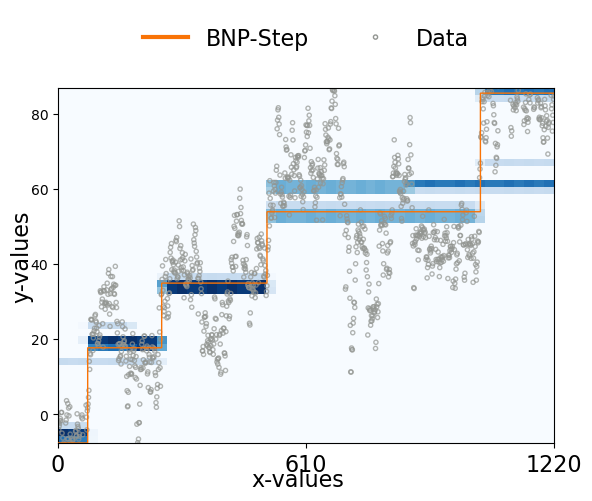

In [8]:
rootdir1 = r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\\'
rootdir2 = r'C:\Users\Yildiz Lab\Desktop\BNP\Stier v2\\'
# sampler = bnp.BNPStep(B_max=122)
sampler.load_data(str(p.parent)+'/241113-01-100126_47094_fiona_tempdata.csv', has_timepoints=False)
sampler.results_from_file(filename=rootdir1+'241113-01-100126_47094_fiona_trial_sample')
sampler.visualize_results(plot_type='step')

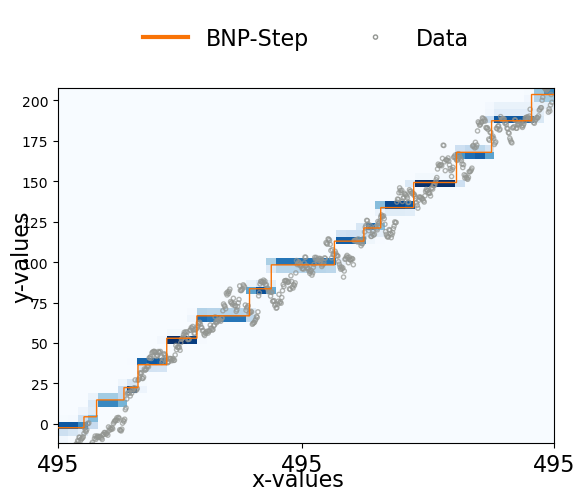

In [17]:
sampler.results_from_file(filename='/Users/slivka/Documents/University of California/Research/2Color/79469_fiona_trial_sample')
sampler.visualize_results(plot_type='step')

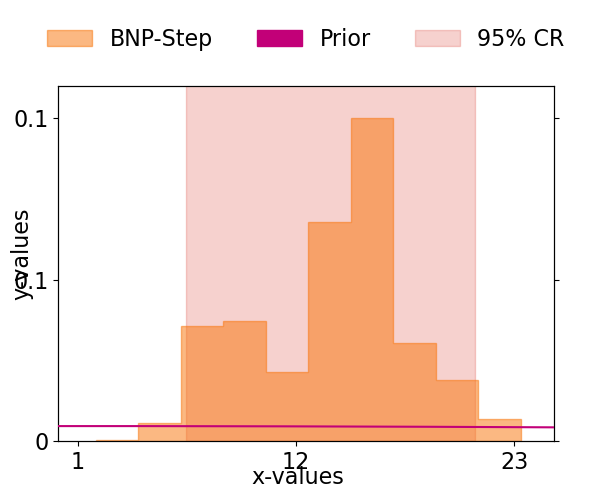

In [18]:
sampler.visualize_results(plot_type='hist_step_height')